In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from loguru import logger
import seaborn as sns

In [4]:
import os
import sys
sys.path.append('..')

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.evaluation import run_experiment, _select_significant_entries, _compute_prec_rec_f1
from pals.common import save_obj, set_log_level_debug, set_log_level_info, set_log_level_warning, DATABASE_PIMP_KEGG, SIGNIFICANT_THRESHOLD
from pals.feature_extraction import DataSource
from pals.pathway_analysis import PALS

2019-12-26 09:31:57.424 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-12-26 09:31:57.425 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-12-26 09:31:58.497 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


# HAT Data Analysis

This notebook is used to generate resampled data and run the different methods for comparison in the manuscript.

### Load data

Assume token is stored in environmental variable *PIMP_API_TOKEN*

In [6]:
token = get_pimp_API_token_from_env()

In [7]:
analysis_id_plasma = 636
int_df_plasma, annotation_df_plasma, experimental_design_plasma = download_from_pimp(token, PIMP_HOST, analysis_id_plasma, 'kegg')

2019-12-26 09:31:58.655 | DEBUG    | pals.pimp_tools:download_from_pimp:119 - Trying to load data from temp file: C:\Users\joewa\AppData\Local\Temp\pimp_analysis_636.p


### Create Data Sources

In [8]:
database_name = DATABASE_PIMP_KEGG
ds_plasma = DataSource(int_df_plasma, annotation_df_plasma, experimental_design_plasma, database_name)

2019-12-26 09:31:59.404 | DEBUG    | pals.feature_extraction:__init__:38 - Using PiMP_KEGG as database
2019-12-26 09:31:59.405 | DEBUG    | pals.feature_extraction:get_database:101 - Loading C:\Users\joewa\Work\git\PALS\pals\data\PiMP_KEGG.json.zip
2019-12-26 09:31:59.428 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-26 09:31:59.435 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-26 09:31:59.797 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


### Grid search over PALS plage and hg parameters

In this section, we compare the difference in pathway ranking due to varying the PLAGE and Hypergeometric parameters.

plage=1 and hg=1 is set as the reference, and other results (with different plage and hg values) are evaluated w.r.t to that.

In [9]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weights = range(1, 11)
pals_hg_weights = range(1, 11)
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
N = None
threshold = SIGNIFICANT_THRESHOLD

In [10]:
set_log_level_info() # don't print too many debug messages during experiment

In [11]:
results = {}
for pals_plage_weight in pals_plage_weights:
    for pals_hg_weight in pals_hg_weights:
        logger.info('Running PALS with plage_weight=%d hg_weight=%d' % (pals_plage_weight, pals_hg_weight))
        
        # run PALS and select the top-N significant pathways from the results
        pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
        full_df_pals = pals.get_pathway_df(resample=pals_resample)
        full_df_pals.sort_values(significant_column, inplace=True)
        pals_full = _select_significant_entries(full_df_pals, significant_column, threshold, N)
        
        # store the results for analysis later
        key = (pals_plage_weight, pals_hg_weight, )
        results[key] = pals_full

2019-12-26 09:32:21.835 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=1
2019-12-26 09:32:27.893 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=2
2019-12-26 09:32:34.061 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=3
2019-12-26 09:32:40.399 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=4
2019-12-26 09:32:47.331 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=5
2019-12-26 09:32:54.140 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=6
2019-12-26 09:33:01.054 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=7
2019-12-26 09:33:07.973 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=8
2019-12-26 09:33:14.725 | INFO     | __main__:<module>:4 - Running PALS with plage_weight=1 hg_weight=9
2019-12-26 09:33:21.443 | INFO     | __main__:<module>:4 - Runni

In [12]:
set_log_level_debug()

Computes Jacard Index between two sets, and uses this as a similarity score in different pathway ranking results.

In [13]:
def jacard_index(s1, s2):
    return float(len(s1.intersection(s2))) / float(len(s1.union(s2)))

In [14]:
pals_plage_weights = np.array(range(1, 11))
pals_hg_weights = np.array(range(1, 11))

reference = (1, 1)
sim_mat = np.zeros((len(pals_plage_weights), len(pals_hg_weights)))

for i in range(len(pals_plage_weights)):
    pals_plage_weight = pals_plage_weights[i]
    
    for j in range(len(pals_hg_weights)):
        pals_hg_weight = pals_hg_weights[j]
        to_check = (pals_plage_weight, pals_hg_weight, )
        s1 = set(results[reference].index.values)
        s2 = set(results[to_check].index.values)
        sim = jacard_index(s1, s2)        
        sim_mat[i, j] = sim

Make a plot of similarity

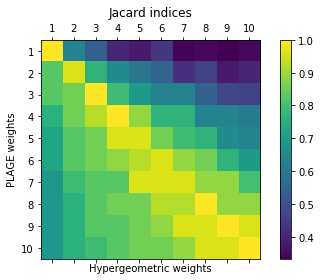

In [21]:
fig, ax = plt.subplots(1, 1)
img = ax.matshow(sim_mat)
ax.set_xticks(pals_hg_weights-1)
ax.set_xticklabels(pals_hg_weights)
ax.set_xlabel('Hypergeometric weights')
ax.set_yticks(pals_plage_weights-1)
ax.set_yticklabels(pals_plage_weights)
ax.set_ylabel('PLAGE weights')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.colorbar(img)
plt.title('Jacard indices', y=1.08)
plt.tight_layout()

plt.savefig(os.path.join('test_data', 'HAT', 'similarity.eps'), dpi=300)

### Compare ORA vs PALS

#### PLAGE weight = 5, hg weight = 1

In [41]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weight = 5
pals_hg_weight = 1
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
case = 'Stage1'
control = 'Control'
N = 20
threshold = SIGNIFICANT_THRESHOLD

Run PALS and ORA on the full data

In [42]:
pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
pals_df = pals.get_pathway_df(resample=pals_resample)
pals_df.sort_values(significant_column, inplace=True)

2019-12-26 10:08:58.369 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-26 10:08:58.451 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2019-12-26 10:08:58.517 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2019-12-26 10:08:58.518 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:216 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2019-12-26 10:09:00.608 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:227 - Calculating plage p-values with resampling
2019-12-26 10:09:00.609 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:231 - Comparison Stage2/Stage1
2019-12-26 10:09:00.610 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:239 - Resampling 0/1000
2019-12-26 10:09:00.741 | DEBUG    | pals.pat

In [43]:
_select_significant_entries(pals_df, significant_column, threshold, None)

,pw_name,p_value,sf,unq_pw_F,tot_ds_F,F_coverage
map00903,Limonene and pinene degradation,0.000000e+00,2.960171e-02,17,5,29.41
map04961,Endocrine and other factor-regulated calcium r...,0.000000e+00,5.514965e-01,7,1,14.29
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000e+00,4.359032e-01,5,1,20.00
map00902,Monoterpenoid biosynthesis,0.000000e+00,4.650501e-02,19,5,26.32
map00930,Caprolactam degradation,4.159425e-18,5.218894e-08,19,12,63.16
map00981,Insect hormone biosynthesis,8.819945e-14,4.002601e-01,21,3,14.29
map05215,Prostate cancer,8.610605e-12,2.532519e-01,9,2,22.22
map04913,Ovarian steroidogenesis,1.117604e-11,5.630889e-01,17,2,11.76
map00622,Xylene degradation,5.743465e-09,9.271170e-05,24,10,41.67
map00626,Naphthalene degradation,2.586911e-07,5.036634e-01,43,5,11.63


#### PLAGE weight = 1, hg weight = 5

In [44]:
significant_column = 'PiMP_KEGG Stage1/Control comb_p'
pals_plage_weight = 1
pals_hg_weight = 5
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
case = 'Stage1'
control = 'Control'
N = 20
threshold = SIGNIFICANT_THRESHOLD

In [45]:
pals = PALS(ds_plasma, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
pals_df = pals.get_pathway_df(resample=pals_resample)
pals_df.sort_values(significant_column, inplace=True)

2019-12-26 10:09:04.974 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2019-12-26 10:09:05.081 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2019-12-26 10:09:05.159 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2019-12-26 10:09:05.159 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:216 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2019-12-26 10:09:07.194 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:227 - Calculating plage p-values with resampling
2019-12-26 10:09:07.194 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:231 - Comparison Stage2/Stage1
2019-12-26 10:09:07.195 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:239 - Resampling 0/1000
2019-12-26 10:09:07.298 | DEBUG    | pals.pat

In [46]:
_select_significant_entries(pals_df, significant_column, threshold, None)

,pw_name,p_value,sf,unq_pw_F,tot_ds_F,F_coverage
map04961,Endocrine and other factor-regulated calcium r...,0.000000e+00,5.514965e-01,7,1,14.29
map07226,"Progesterone, androgen and estrogen receptor a...",0.000000e+00,4.359032e-01,5,1,20.00
map00330,Arginine and proline metabolism,2.041448e-11,7.407819e-14,79,34,43.04
map00930,Caprolactam degradation,3.278140e-10,5.218894e-08,19,12,63.16
map00622,Xylene degradation,7.047319e-07,9.271170e-05,24,10,41.67
map00260,"Glycine, serine and threonine metabolism",4.865798e-06,8.567758e-10,41,20,48.78
map00250,"Alanine, aspartate and glutamate metabolism",8.304057e-06,8.123660e-06,23,11,47.83
map00770,Pantothenate and CoA biosynthesis,1.192404e-05,2.939498e-06,25,12,48.00
map00643,Styrene degradation,2.832901e-05,3.617463e-05,18,9,50.00
map02010,ABC transporters,2.926844e-05,6.859291e-08,79,26,32.91
